# Evaluating and Retraining VGG-16 Model:
---

## Outline of tasks performed in this notebook:
* Load the phase-1 model (vgg16)
* Test performance on pggan and stargan generated images
* Retrain the model with 140k+pggan+stargan data (if needed)
* Test the performance on pggan_all and stargan_all (Expected to perform better)

[/kaggle/input/vgg16-diag](http://)

## Imports, Settings and Globals:

In [1]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from pylab import *
from keras.callbacks import LearningRateScheduler
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
import itertools
from sklearn.metrics import confusion_matrix
from keras import optimizers
from PIL import Image
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** np.floor(epoch / step_size))
        return LearningRateScheduler(schedule)

In [3]:
lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=2)

### Load trained model from Phase-1

In [4]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/kaggle/input/model-vgg16-final/model_vgg16_final.h5')

In [5]:
# Print model summary 
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 134,264,641
Trainable params: 119,549,953
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
# Load pggan images to test the performance:
test_datagen_pggan = ImageDataGenerator()
TEST_DIR_pggan = '/kaggle/input/pggan-all/pggan_v1_v2/test'
test_generator_pggan = test_datagen_pggan.flow_from_directory(TEST_DIR_pggan,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

Found 7907 images belonging to 2 classes.


In [7]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator_pggan)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

248/248 [==============================] - 78s 266ms/step - loss: 4.4617 - accuracy: 0.5020
Test loss: 4.461669921875
Test accuracy: 0.501960277557373


In [8]:
# Check prediction probabilities: 
THRESHOLD = 0.5
test_predict_probability_pggan = new_model.predict(test_generator_pggan)
test_predict_pggan = np.where(test_predict_probability_pggan > THRESHOLD, 1, 0)

test_predict_pggan

248/248 [==============================] - 38s 154ms/step


array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [1]])

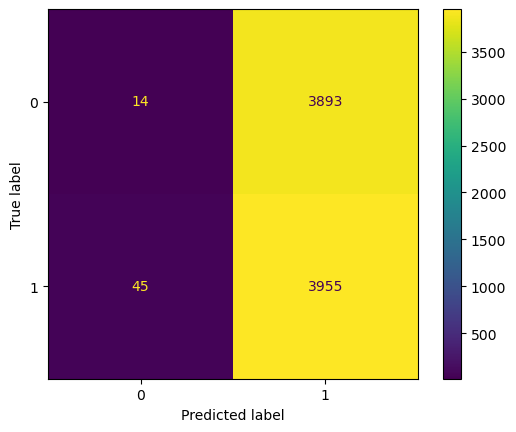

In [9]:
# Plotting confusion matrix to better understand teh results
cm = confusion_matrix(test_generator_pggan.classes, test_predict_pggan, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Result:
#### As expected, the model did not perform well on PGGAN generated fake images.

### Evaluate model's performance on STARGAN generated fake images data:

In [10]:
# Load stargan images to test the performance:
test_datagen_stargan = ImageDataGenerator()
TEST_DIR_stargan = '/kaggle/input/stargan-test/stargan_test'
test_generator_stargan = test_datagen_stargan.flow_from_directory(TEST_DIR_stargan,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

Found 8000 images belonging to 2 classes.


In [ ]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator_stargan)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 63s 250ms/step - loss: 4.9739 - accuracy: 0.4922


In [ ]:
# Check prediction probabilities: 
THRESHOLD = 0.5
test_predict_probability_stargan = new_model.predict(test_generator_stargan)
test_predict_stargan = np.where(test_predict_probability_stargan > THRESHOLD, 1, 0)

test_predict_stargan

In [ ]:
# Plotting confusion matrix to better understand teh results
cm = confusion_matrix(test_generator_stargan.classes, test_predict_stargan, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Result:
#### As expected, the model did not perform well on STARGAN generated fake images.

### Conclusion:
#### From the above results, we can infer that the model did not perform well in detecting the fake images generated by different GANs. Hence, we need to retrain the model to learn from the such diverse data which contains images generated by PGGAN and STARGAN.

#### Loading all-gan-data dataset which contains original 140k_real_and_fake_faces along with additional PGGAN and STARGAN generated images for retraining the model:
* STYLEGAN = 100k
* PGGAN = 40k
* STARGAN = 20k

In [ ]:
# Load train dataset
TRAINING_DIR = '/kaggle/input/all-gan-data/all_data/real-vs-fake/train'
train_datagen = ImageDataGenerator(
      # rescale=1./255
      # ,rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,target_size=(224,224),batch_size=32,class_mode='binary')

# Load validation dataset
VALIDATION_DIR = '/kaggle/input/all-gan-data/all_data/real-vs-fake/valid'
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,target_size=(224,224),batch_size=32,class_mode='binary');

In [ ]:
# Load test dataset
test_datagen = ImageDataGenerator()
TEST_DIR = '/kaggle/input/all-gan-data/all_data/real-vs-fake/test'
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

In [ ]:
history = new_model.fit(
      train_generator,
      steps_per_epoch=500,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10,
      callbacks=[lr_sched]
)

In [ ]:
# Save the retrained model
new_model.save('vgg16_phase2_retrained.h5')

### Evaluate model's performance on a diverse test dataset of fake images:

In [ ]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Plot confusion matrix to better understand the results
cm = confusion_matrix(test_generator.classes, test_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Evaluate retrained model's performance on PGGAN generated fake images data:

In [ ]:
# Check pggan test performance:
test_datagen_pggan = ImageDataGenerator()
TEST_DIR_pggan = '/kaggle/input/pggan-all/pggan_v1_v2/test'
test_generator_pggan = test_datagen_pggan.flow_from_directory(TEST_DIR_pggan,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

In [ ]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator_pggan)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Check prediction probabilities:
THRESHOLD = 0.5
test_predict_probability_pggan = new_model.predict(test_generator_pggan)
test_predict_pggan = np.where(test_predict_probability_pggan > THRESHOLD, 1, 0)

test_predict_pggan

In [ ]:
# Plot confusion matrix to better understand the results
cm = confusion_matrix(test_generator_pggan.classes, test_predict_pggan, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Conclusion:
#### The retrained model performed well on the PGGAN generated fake images dataset.

In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/kaggle/working/vgg19_retrained.h5')
new_model.summary()

### Evaluate retrained model's performance on STARGAN generated fake images data:

In [ ]:
# Check stargan test performance:
test_datagen_stargan = ImageDataGenerator()
TEST_DIR_stargan = '/kaggle/input/stargan-test/stargan_test'
test_generator_stargan = test_datagen_stargan.flow_from_directory(TEST_DIR_stargan,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

In [ ]:
# Check Test loss and accuracy:
score = new_model.evaluate(test_generator_stargan)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Check prediction probabilities:
THRESHOLD = 0.5
test_predict_probability_stargan = new_model.predict(test_generator_stargan)
test_predict_stargan = np.where(test_predict_probability_stargan > THRESHOLD, 1, 0)

test_predict_stargan

In [ ]:
# Plot confusion matrix to better understand the results
cm = confusion_matrix(test_generator_stargan.classes, test_predict_stargan, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Conclusion:
#### The retrained model performed well on the STARGAN generated fake images dataset.